In [195]:
import pandas as pd

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re

In [196]:
df = pd.read_excel("data train.xlsx")

In [197]:
df['sentiment'] = df['sentiment'].fillna(value=2)
df['sentiment'] = df['sentiment'].astype(int)
df['text'] = df['text'].replace('\s+', ' ', regex=True)
df['text'] = df['text'].fillna('').apply(str)
df['text'] = df['text'].replace({'"':'',
                                 '\d+':'',
                                 ':':'',
                                 ';':'',
                                 '#':'',
                                 '@':'',
                                 '_':'',
                                 ',': '',
                                 "'": '',
                                  }, regex=True)

df['text'] = df['text'].str.replace(r'[https]+[?://]+[^\s<>"]+|www\.[^\s<>"]+[?()]+[(??)]+[)*]+[(\xa0]+[-&gt...]', "",regex=True)

df['text'] = df['text'].replace('\n','', regex=True)

df['text'] = df['text'].replace({'\.':'','(/)':'','\(':'','\)':''},regex=True)
df['text'] = df['text'].replace('[\.:"]','',regex =True)

df['text'] = df['text'].fillna('').apply(str)

df['text'].astype(str)
letters_only = re.sub("[^a-zA-Z]",  # Search for all non-letters
                          " ",          # Replace all non-letters with spaces
                          str(df['text']))
df['text'] = df['text'].str.strip()
df['text'] = df['text'].str.lower()

In [198]:
df['sentiment'] = df['sentiment'].replace({1:0,2:1,3:2})
df.head(100)

,text,sentiment,Unnamed: 2
0,menurut johnny g plate upaya itu sama seperti ...,1,NaN
1,raymax justbob adisareang wah punya pt pos ind...,1,NaN
2,bgkyrborn mastbp liaisti ellykoro mamakeabien ...,1,NaN
3,telegram bukannya jaman jadul banget tuh produ...,2,NaN
4,agenda transformatif ini tidak hanya ditujukan...,2,NaN
...,...,...,...
95,bravobeacukai dimana saya bisa hubungi pos ind...,1,NaN
96,bravobeacukai punten ingin tanya kakkalau impo...,1,NaN
97,briankhis amaan kok tegantung deh kan ada mace...,1,NaN
98,brklynbrnx paket lbde sudah rilis dan lunas pa...,1,NaN


In [199]:
df_neg = df[df['sentiment'] == 0]
df_net = df[df['sentiment'] == 1]
df_pos = df[df['sentiment'] == 2]
print(f"negatif shape {df_neg.shape}")
print(f"netral shape {df_net.shape}")
print(f"postif shape {df_pos.shape}")
print(f"total shape {df.shape}")

negatif shape (404, 3)
netral shape (484, 3)
postif shape (640, 3)
total shape (1528, 3)


In [200]:
X = df['text']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [201]:
vocab_size = 20000
embedding_dim = 10
max_length = 150
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

In [202]:
import numpy as np
tokenizer = Tokenizer(num_words=vocab_size,oov_token=oov_tok)
tokenizer.fit_on_texts(X)

word_index =tokenizer.word_index

training_sequence = tokenizer.texts_to_sequences(X_train)
testing_sequence = tokenizer.texts_to_sequences(X_test)

training_padding = pad_sequences(training_sequence,maxlen=max_length,padding=padding_type)
test_padding = pad_sequences(training_sequence,maxlen=max_length,padding=padding_type)

training_padded = np.array(training_padding)
training_label = np.array(y_train)

test_padded = np.array(test_padding)
test_label = np.array(y_test)

In [203]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length ),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(20,activation='sigmoid'),
    tf.keras.layers.Dense(40,activation='sigmoid'),
    tf.keras.layers.Dense(3,activation='sigmoid')

])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [204]:
num_epoch = 300
history = model.fit(training_padded,training_label,batch_size = 32,epochs=num_epoch)

Epoch 1/300
39/39 [==============================] - 0s 1ms/step - loss: 1.2541 - accuracy: 0.2758
Epoch 2/300
39/39 [==============================] - 0s 822us/step - loss: 1.0852 - accuracy: 0.4100
Epoch 3/300
39/39 [==============================] - 0s 822us/step - loss: 1.0832 - accuracy: 0.4100
Epoch 4/300
39/39 [==============================] - 0s 822us/step - loss: 1.0829 - accuracy: 0.4100
Epoch 5/300
39/39 [==============================] - 0s 822us/step - loss: 1.0824 - accuracy: 0.4100
Epoch 6/300
39/39 [==============================] - 0s 1ms/step - loss: 1.0828 - accuracy: 0.4100

In [205]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy'])


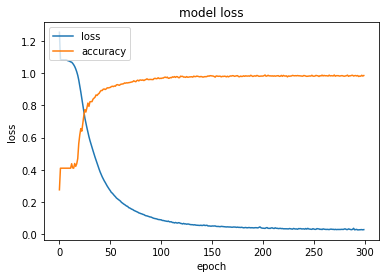

In [206]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'accuracy'], loc='upper left')
plt.show()

In [207]:
sentence = ["kurir pos lama"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences,maxlen=max_length,padding=padding_type,truncating=trunc_type)
predic2 = model.predict(padded)

[[1. 1. 0.]]
[[0.89539385 0.87373775 0.00150934]]


In [208]:
import numpy as np

y_label = {0:"negative",1:"neutral",2:"positive"}

prediction = np.array(predic)
print(y_label[np.argmax(prediction)])


negative


In [235]:
data_predict = pd.read_excel("data done 1.xlsx")
data_predict = df.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))
data_predict.head()
data_predict = data_predict.dropna()
data_predict.isna().sum()
data_predict

,text,sentiment,Unnamed: 2
0,menurut johnny g plate upaya itu sama seperti ...,1,nan
1,raymax justbob adisareang wah punya pt pos ind...,1,nan
2,bgkyrborn mastbp liaisti ellykoro mamakeabien ...,1,nan
3,telegram bukannya jaman jadul banget tuh produ...,2,nan
4,agenda transformatif ini tidak hanya ditujukan...,2,nan
...,...,...,...
1523,yuk ah udah pada install pospay belum? jangan ...,2,nan
1524,yuk ah udah pada install pospay belum? jangan ...,2,nan
1525,yuk ah udah pada install pospay belum? jangan ...,2,nan
1526,yuk share pernah ada cerita menarik apa tentan...,1,nan


In [233]:
data_done = data_predict.drop(['sentiment','Unnamed: 2'])

KeyError: "['sentiment' 'Unnamed: 2'] not found in axis"

[['menurut johnny g plate upaya itu sama seperti perjuangan soetoko bersama para pahlawan angkatan muda pos telegraf dan telepon amptt di mana amptt membebaskan jawatan ptt yang sekaligus merintis awal mula sektor pos dan telekomunikasi indonesia',
  'raymax justbob adisareang wah punya pt pos indonesia ya?',
  'bgkyrborn mastbp liaisti ellykoro mamakeabien hemaviton moga pelayanannya jg lbh hebat lg yajgn sampe pos indonesia masuk bottom worst lg*pengalaman tukang sortir ga suka robek perangko lg kan?? *pengalamanlagi',
  'telegram bukannya jaman jadul banget tuh produk pos indonesia yang kalau dapat telegram pasti langsung shock banyakan berita duka cita',
  'agenda transformatif ini tidak hanya ditujukan agar sektor pos dan telekomunikasi indonesia dapat semakin maju tetapi juga untuk mendorong perluasan akses dan kebermanfaatan teknologi digital',
  'banpolpecatan chueng ainaalit dyananjani candraasmara anaksngkong wah keren pos indonesia makin maju',
  'keren pos indonesia mengiku

In [ ]:
sequences = tokenizer.texts_to_sequences(data_predict)
padded = pad_sequences(sequences,maxlen=max_length,padding=padding_type,truncating=trunc_type)
data_prediction = model.predict(padded)
sequences

In [212]:
data_testing = pd.read_excel("data clear.xlsx")
data_testing

,text
0,ayo jawab siapa yg baru tau kalau pos indonesi...
1,oktober memperingati hari kesaktian pancasila ...
2,alasan sederhana mau coba download pospayoffic...
3,tercatat sampai dengan semester i pertumbuhan ...
4,digitalisasi di tubuh pt pos indonesia diwujud...
...,...
874,unfortunately pos malaysia only delivers to th...
875,kapankah anda terakhir kali menulis surat masi...
876,po case album aespa savage ditunggu sampai k ...
877,checkout all nominal shopee split pay shopeepa...
